In [1]:
import pandas as pd
from tqdm import tqdm


import numpy as np

In [3]:
df = pd.read_csv('text_emotion.csv')

## Classes

In [4]:
classes = sorted(list(set(df['sentiment'])))
no_classes = len(classes)

## Pre-processing

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf

In [11]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import re

stop = stopwords.words('english')
#df['text'] = df['content'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [9]:
def clean_text(data):
    data=re.sub(r"(#[\d\w\.]+)", '', data)
    data = data.lower()
    data=word_tokenize(data)
    data = ' '.join(data)
    return data

In [12]:
df['text'] = df['content'].apply(clean_text)

In [13]:
class_mapping = {}
for idx, name in enumerate(classes):
    class_mapping[name] = idx 

In [14]:
_ = df.pop('tweet_id')
_ = df.pop('author')

In [15]:
df['label'] = df['sentiment'].apply(lambda x : class_mapping[x])

In [16]:
class_weight = {}
for i in range(no_classes):
    num = len(df[df['label'] == i])
    class_weight[i] = num / len(df) 

### Train - Test Split

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
def build_dataset(df, feature='text', target='label'):
    dataset = (
                tf.data.Dataset.from_tensor_slices(
                    (
                        tf.cast(df[feature].values, tf.string),
                        tf.cast(df[target].values, tf.int32)
                    )
                )
            )
    return dataset

In [19]:
df_train, df_test = train_test_split(df, test_size = 0.2)
df_train, df_val = train_test_split(df_train, test_size = 0.2)

train_dataset = build_dataset(df_train)
val_dataset = build_dataset(df_val)
test_dataset = build_dataset(df_test)

In [20]:
BUFFER_SIZE = 10000
BATCH_SIZE = 128

In [21]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [22]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [23]:
model = tf.keras.Sequential([
    encoder,
    
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),
                              output_dim=64, mask_zero=True),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    
    tf.keras.layers.Dense(64, activation='relu'),
    #tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(no_classes)
])

In [24]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [25]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  verbose=1,patience=10,
                                                  mode='max', restore_best_weights=True)

In [26]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

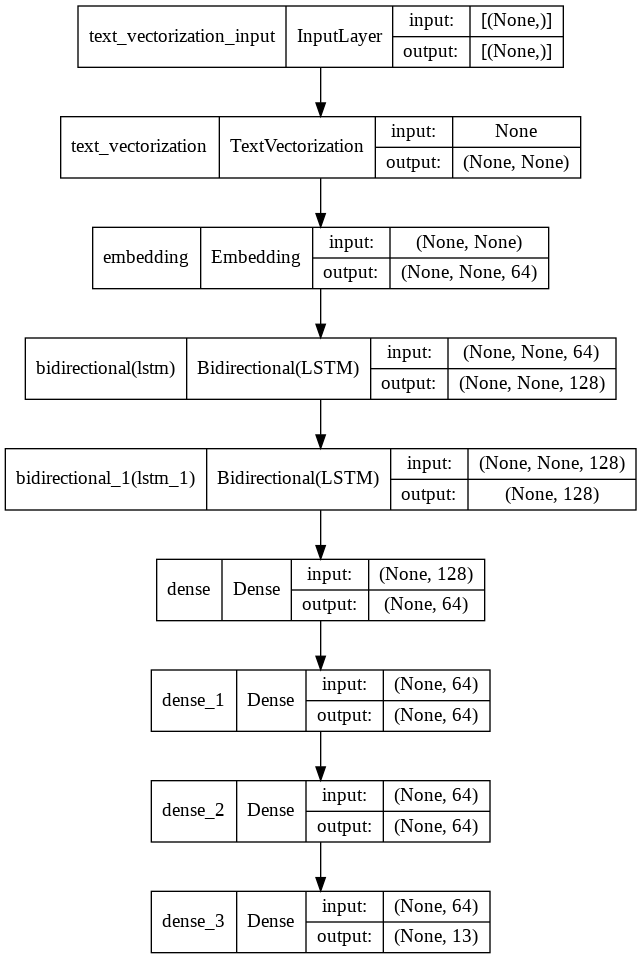

In [37]:
from keras.utils.vis_utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True)

In [27]:
history = model.fit(train_dataset, epochs = 50,
                    validation_data=val_dataset,
                    validation_steps=30,
                    class_weight = class_weight)

Epoch 1/50
200/200 [==============================] - 61s 230ms/step - loss: 0.2930 - accuracy: 0.2158 - val_loss: 2.4024 - val_accuracy: 0.2242
Epoch 2/50
200/200 [==============================] - 41s 206ms/step - loss: 0.2429 - accuracy: 0.2410 - val_loss: 2.3543 - val_accuracy: 0.2557
Epoch 3/50
200/200 [==============================] - 41s 206ms/step - loss: 0.2380 - accuracy: 0.2506 - val_loss: 2.2948 - val_accuracy: 0.2688
Epoch 4/50
200/200 [==============================] - 42s 207ms/step - loss: 0.2358 - accuracy: 0.2520 - val_loss: 2.3444 - val_accuracy: 0.2497
Epoch 5/50
200/200 [==============================] - 41s 206ms/step - loss: 0.2338 - accuracy: 0.2521 - val_loss: 2.2685 - val_accuracy: 0.2685
Epoch 6/50
200/200 [==============================] - 41s 207ms/step - loss: 0.2310 - accuracy: 0.2555 - val_loss: 2.2524 - val_accuracy: 0.2724
Epoch 7/50
200/200 [==============================] - 41s 207ms/step - loss: 0.2273 - accuracy: 0.2681 - val_loss: 2.2886 - val_ac

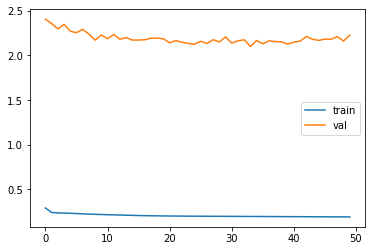

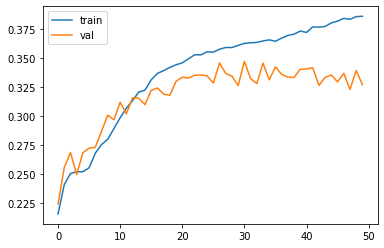

In [28]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

plt.figure(2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

## Evaluate it against test

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [30]:
model.evaluate(test_dataset)

63/63 [==============================] - 4s 59ms/step - loss: 2.2023 - accuracy: 0.3355


[2.202253818511963, 0.33550000190734863]

In [31]:
pred = model.predict(test_dataset)
y_test = list(df_test.label)

In [32]:
import numpy as np

pred_idx = []
target_idx = []

for i in tqdm(range(len(pred))):
    pred_idx.append(np.argmax(pred[i]))
    target_idx.append(y_test[i])

100%|██████████| 8000/8000 [00:00<00:00, 313507.85it/s]


In [33]:
print(classification_report(target_idx, pred_idx, target_names=classes))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        19
     boredom       0.00      0.00      0.00        41
       empty       0.00      0.00      0.00       165
  enthusiasm       0.00      0.00      0.00       157
         fun       0.00      0.00      0.00       372
   happiness       0.33      0.31      0.32      1050
        hate       0.00      0.00      0.00       267
        love       0.50      0.29      0.37       737
     neutral       0.33      0.67      0.44      1773
      relief       0.00      0.00      0.00       306
     sadness       0.33      0.02      0.03       995
    surprise       0.00      0.00      0.00       439
       worry       0.32      0.57      0.41      1679

    accuracy                           0.34      8000
   macro avg       0.14      0.14      0.12      8000
weighted avg       0.27      0.34      0.26      8000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
print(confusion_matrix(target_idx, pred_idx))

[[   0    0    0    0    0    1    0    0    4    0    0    0   14]
 [   0    0    0    0    0    1    0    0   19    0    0    0   21]
 [   0    0    0    0    0    6    0    1  109    0    0    0   49]
 [   0    0    0    0    0   14    0    3   92    0    2    0   46]
 [   0    0    0    0    0   72    0   16  175    0    0    0  109]
 [   0    0    0    0    0  322    0   90  442    0    4    0  192]
 [   0    0    0    0    0    4    0    1   87    0    2    0  173]
 [   0    0    0    0    0  182    0  213  202    0    6    0  134]
 [   0    0    0    0    0  128    0   36 1181    0    2    0  426]
 [   0    0    0    0    0   61    0   15  146    0    2    0   82]
 [   0    0    0    0    0   43    0    9  290    0   18    0  635]
 [   0    0    0    0    0   58    0   17  207    0    1    0  156]
 [   0    0    0    0    0   88    0   27  597    0   17    0  950]]
